In [92]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

%run diagnostics.ipynb


In [55]:
cols_to_drop = ['timestamp', 'lexeme_id', 'word', 'user_id', 'avg_user_p_recall', 'ui_language', 'learning_language']
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')
dff = pd.merge(pd.merge(df_words, df, on = 'lexeme_id', how='inner'), df_users, on = ['user_id', 'lang_combination'], how='inner')
dff.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [56]:
dff.columns

Index(['gender', 'def', 'tense', 'POS', 'person', 'number', 'word_len',
       'tags_list', 'SUBTLEX', 'p_recall', 'delta', 'history_seen',
       'history_correct', 'session_seen', 'session_correct', 'h_recall',
       'lang_combination', 'avg_delta', 'std_delta', 'avg_h_recall'],
      dtype='object')

In [57]:
# Handle tags 
# 1) Store tags as list, but delete rows where there are less than x occurences 
dff_1 = dff.copy()
tag_counts = dff_1['tags_list'].value_counts()
rare_threshold = 1000
dff_1['tags_list'] = dff_1['tags_list'].apply(lambda x: x if tag_counts[x] > rare_threshold else 'rare')

dff_1.drop(columns=['POS', 'person', 'number', 'gender', 'tense', 'def'], inplace=True)
dff_1.dropna(inplace=True)

# 2) Store each tag as column, replace NaN values with a placeholder for categorical columns
# categorical_cols = dff.select_dtypes(include=['object']).columns.tolist()
# dff_2 = dff.copy()
# dff_2[categorical_cols] = dff_2[categorical_cols].fillna('missing')
# dff_2.drop(columns=['tags_list'], inplace=True)

In [58]:
# VIF -> iteratevily delete columns that had VIF > 10
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data
    
dff_VIF = dff_1.drop(columns=['p_recall','history_correct', 'history_seen']).sample(2000000)
vif = calculate_vif(dff_VIF.select_dtypes(exclude='O'))
vif

,Feature,VIF
0,word_len,7.97491
1,SUBTLEX,1.43898
2,delta,1.98427
3,session_seen,30.45361
4,session_correct,28.06076
5,h_recall,51.43665
6,avg_delta,4.09944
7,std_delta,3.94932
8,avg_h_recall,63.23867


In [59]:
removed_features = ["avg_h_recall", 'history_correct']
correlation_with_target = dff_1[removed_features + ["p_recall"]].corr()["p_recall"]
print(correlation_with_target)

avg_h_recall      0.16471
history_correct   0.00041
p_recall          1.00000
Name: p_recall, dtype: float64


In [60]:
dff_final = dff_1.sample(frac=1)
# dff_final = dff_2

In [61]:
# Transforming skewed variables
dff_final['history_wrong'] = np.log2(1+(dff_final['history_seen']-dff_final['history_correct']))
dff_final['delta'] = np.sqrt(dff_final['delta']/(60*60*24))
dff_final['avg_delta'] = np.sqrt(dff_final['avg_delta']/(60*60*24))
dff_final['history_seen'] = np.log2(1+dff_final['history_seen'])
dff_final['history_correct'] = np.log2(1+dff_final['history_correct'])
# dff['SUBTLEX'] = np.log2(dff['SUBTLEX'])

In [62]:
dff_final[['word_len', 'SUBTLEX', 'delta', 'history_seen', 'history_correct', 'h_recall', 'std_delta', 'avg_h_recall', 'history_wrong', 'avg_delta', 'p_recall']].corr()['p_recall'].sort_values()

history_wrong     -0.08021
delta             -0.04040
avg_delta         -0.03256
std_delta         -0.02151
SUBTLEX           -0.01149
history_seen      -0.00403
history_correct    0.01177
word_len           0.01526
h_recall           0.10367
avg_h_recall       0.16471
p_recall           1.00000
Name: p_recall, dtype: float64

In [63]:
# Transformation of target variable 

# Logit transformation 
def logit_transform(y, epsilon=1e-10):
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

def inverse_logit_transform(y):
    return 1 / (1 + np.exp(-y))


# Log transformation 
def log_transform(y, epsilon=1e-10):
    return np.log(y + epsilon)

def inverse_log_transform(y):
    return np.exp(y)


# Box-Cox transformation
power_transformer = PowerTransformer(method='box-cox', standardize=False)
def power_transform(y, epsilon=1e-10):
    return power_transformer.fit_transform(y+epsilon) 

def inverse_power_transform(y, epsilon=1e-10):
    return power_transformer.inverse_transform(y+epsilon) 

In [64]:
# Create df without word features 
# dff_t = dff_final.drop(columns=['tags_list', 'word_len', 'SUBTLEX'], errors='ignore')

# df without SUBTLEX
# dff_t = dff_final.drop(columns=['SUBTLEX'], errors='ignore')

# DF original 
# dff_s = dff_final.drop(columns=['SUBTLEX', 'tags_list', 'word_len', 'avg_delta', 'std_delta', 'avg_h_recall', 'lang_combination', 'h_recall'], errors='ignore')

# DF without history correct and seen
# dff_s = dff_final.drop(columns=['history_correct', 'history_seen'], errors='ignore')

# DF without user columns 
# dff_u = dff_final.drop(columns=['avg_delta', 'std_delta', 'avg_h_recall', 'h_recall'], errors='ignore')

# DF without lang ui and lang native
# dff_u = dff_final.drop(columns=['ui_language', 'learning_language'], errors='ignore')


In [65]:
def ohe(df):
    """
    One-hot encode categorical variables
    """ 
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    ohe_data = ohe.fit_transform(df[categorical_cols])
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_cols))
    df_encoded = pd.concat([df.select_dtypes(exclude='O'), ohe_df], axis=1)
    df_encoded.dropna(inplace=True)
    return df_encoded

In [66]:
def split_dataset(df):
    X = df.drop(columns='p_recall')
    y = df['p_recall']
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    
    X_test_session = X_test[['session_seen', 'session_correct']]

    X_test.drop(columns=['session_seen', 'session_correct'], inplace=True)
    X_train.drop(columns=['session_seen', 'session_correct'], inplace=True)

    return X_train, X_test, y_train, y_test, X_test_session

In [67]:
def cap_y(prediction): 
    return np.clip(prediction, 0, 1)

In [68]:
dff_encoded = ohe(dff_final)
# dff_t_encoded = ohe(dff_t)
# dff_s_encoded = ohe(dff_s)
# dff_u_encoded = ohe(dff_u)


X_train, X_test, y_train, y_test, X_test_session = split_dataset(dff_encoded)
# X_train_t, X_test_t, y_train_t, y_test_t = split_dataset(dff_t_encoded)
# X_train_s, X_test_s, y_train_s, y_test_s = split_dataset(dff_s_encoded)
# X_train_u, X_test_u, y_train_u, y_test_u = split_dataset(dff_u_encoded)

In [69]:
def create_pipeline(model_type="linear"):
    """
    Create a pipeline for regression with optional feature selection.
    
    Returns:
    - Pipeline object
    """
    if model_type == "ridge":
        model = Ridge(alpha=0.1, fit_intercept=True)
    else:
        model = LinearRegression()

    steps = [
        ('scaler', StandardScaler()),
        # ('polynomial_features', PolynomialFeatures(degree=3, include_bias=False)),
        ('model', model)
        # ('model', TransformedTargetRegressor(regressor=model, 
        #                                     func=log_transform,
        #                                     inverse_func=inverse_log_transform))
    ]
    return Pipeline(steps)

In [70]:
def train_predict(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)

    y_train_pred = cap_y(pipeline.predict(X_train))
    y_test_pred = cap_y(pipeline.predict(X_test)) 

    return y_train_pred, y_test_pred

In [71]:
# Define Configurations for Pipelines
def regression_results(X_train, X_test, y_train, y_test, importance=True):
    
    pipeline = create_pipeline()
    y_train_pred, y_test_pred = train_predict(pipeline, X_train, X_test, y_train, y_test)
    
    # Calculate metrics 
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    print(f"Train R2 = {round(train_r2, 4)}, Test R2 = {round(test_r2,4)}, Train MAE = {round(train_mae,4)}, Test MAE = {round(test_mae, 4)}")

    
    if importance:
        model = pipeline.named_steps["model"]
        coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})

    print('Intercept:', model.intercept_)
    
    full_df = X_test.copy()
    full_df['predictions'] = y_test_pred
    full_df['p_recall'] = y_test

    return coefficients_df, full_df

In [72]:
print('Results for all features')
coefficients_df, full_df = regression_results(X_train, X_test, y_train, y_test)

# print('Results after deleting word features')
# results_t, importance_t, full_df_t = regression_results(pipelines_config, X_train_t, X_test_t, y_train_t, y_test_t, importance='Yes')

# print('Results without word and user features')
# results_s, importance_s, full_df_s  = regression_results(pipelines_config, X_train_s, X_test_s, y_train_s, y_test_s, importance='Yes')

# print('Results without user features') 
# results_u, importance_u, full_df_u = regression_results(pipelines_config, X_train_u, X_test_u, y_train_u, y_test_u, importance='No')

Results for all features
Train R2 = 0.0332, Test R2 = 0.0336, Train MAE = 0.1663, Test MAE = 0.1662
Intercept: 0.8972915870898345


In [73]:
# Examine coefficients  
def out_filepath(filename):
    return os.path.normpath(os.path.join(current_dir, '../reports', filename))
    
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
coefficients_df['Coefficient'] = round(coefficients_df['Coefficient'], 6)

Text(0.5, 1.0, 'Linear Regression residuals histogram')

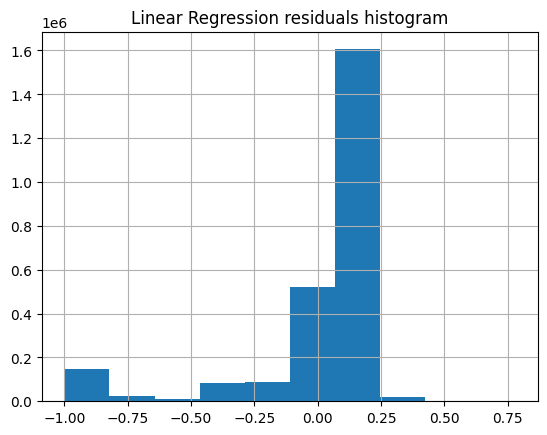

In [74]:
# Examine residuals 
full_df['diff'] = full_df['p_recall'] - full_df['predictions']
resiuals_plot = full_df['diff'].hist()
plt.title('Linear Regression residuals histogram')

Text(0.5, 1.0, 'Predicted vs. Actual Recall Probability')

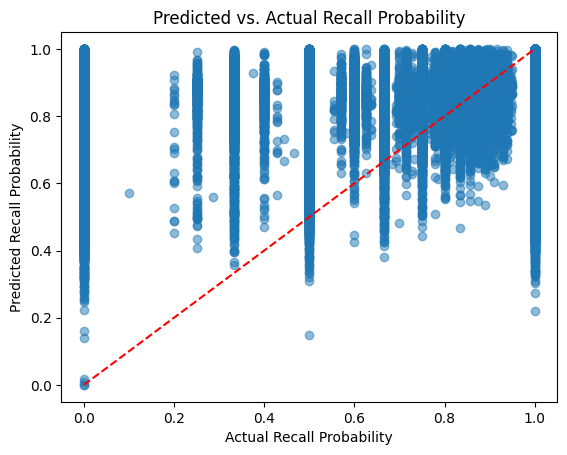

In [75]:
# Predictions vs actual recall probabilities 
predictions_scatterplot = plt.scatter(full_df['p_recall'], full_df['predictions'], alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")

In [76]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

full_df[['p_recall', 'predictions']].describe()

,p_recall,predictions
count,2500200.00000,2500200.00000
mean,0.89736,0.89732
std,0.26989,0.04913
min,0.00000,0.00000
25%,1.00000,0.87598
50%,1.00000,0.90381
75%,1.00000,0.92765
max,1.00000,1.00000


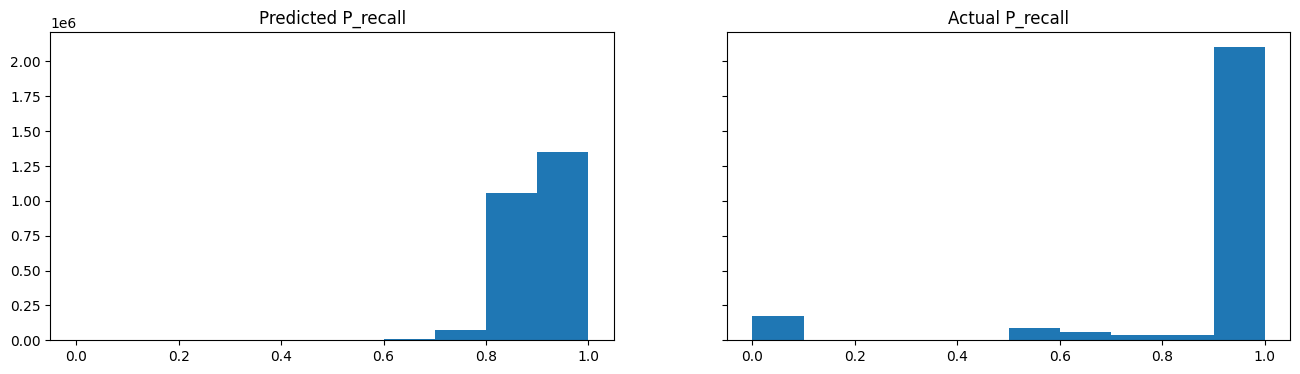

In [77]:
p_recall_histogram, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Predicted P_recall')
ax2.hist(full_df['p_recall'])
ax2.set_title('Actual P_recall')
ax1.hist(full_df['predictions'])
p_recall_histogram.set_size_inches(16, 4)

In [78]:

pd.set_option('mode.chained_assignment', None)

results = full_df[['predictions', 'p_recall']]
results['session_seen'] = X_test_session['session_seen']
results['session_correct'] = X_test_session['session_correct']

In [79]:
results

,predictions,p_recall,session_seen,session_correct
10196070,0.89909,1.00000,1.00000,1.00000
6972842,0.90938,1.00000,5.00000,5.00000
5941394,0.93381,1.00000,3.00000,3.00000
1578630,0.87383,1.00000,1.00000,1.00000
10240945,0.88491,0.00000,1.00000,0.00000
...,...,...,...,...
11372842,0.97972,1.00000,1.00000,1.00000
6898031,0.87184,1.00000,4.00000,4.00000
9513822,0.98323,1.00000,4.00000,4.00000
1445261,0.89033,1.00000,1.00000,1.00000


In [80]:
expanded_df = results.loc[results.index.repeat(results["session_seen"])].reset_index(drop=True)
expanded_df["outcome"] = np.concatenate([
    np.concatenate([np.ones(int(c)), np.zeros(int(s - c))])  # c correct, (s-c) incorrect
    for s, c in zip(results["session_seen"], results["session_correct"])
])

In [81]:
expanded_df[expanded_df['p_recall']<1]

,predictions,p_recall,session_seen,session_correct,outcome
10,0.88491,0.00000,1.00000,0.00000,0.00000
53,0.90760,0.50000,2.00000,1.00000,1.00000
54,0.90760,0.50000,2.00000,1.00000,0.00000
55,0.93996,0.66667,3.00000,2.00000,1.00000
56,0.93996,0.66667,3.00000,2.00000,1.00000
...,...,...,...,...,...
4536138,0.89772,0.80000,5.00000,4.00000,1.00000
4536139,0.89772,0.80000,5.00000,4.00000,1.00000
4536140,0.89772,0.80000,5.00000,4.00000,1.00000
4536141,0.89772,0.80000,5.00000,4.00000,0.00000


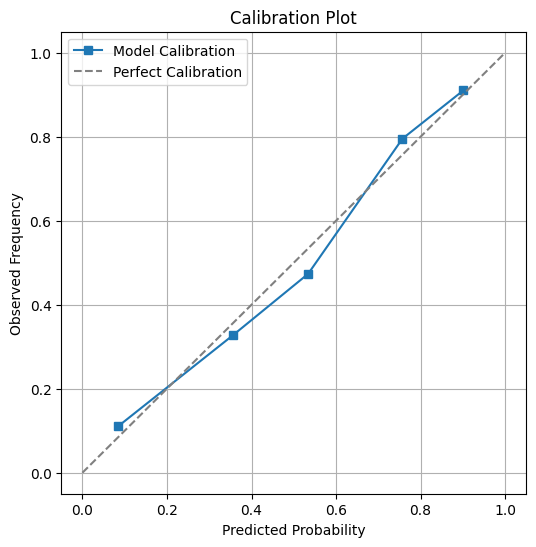

In [82]:
plot_calibration(expanded_df['outcome'], expanded_df['predictions'], 'LR_calibration_plot.png')

AUC Score: 0.6160


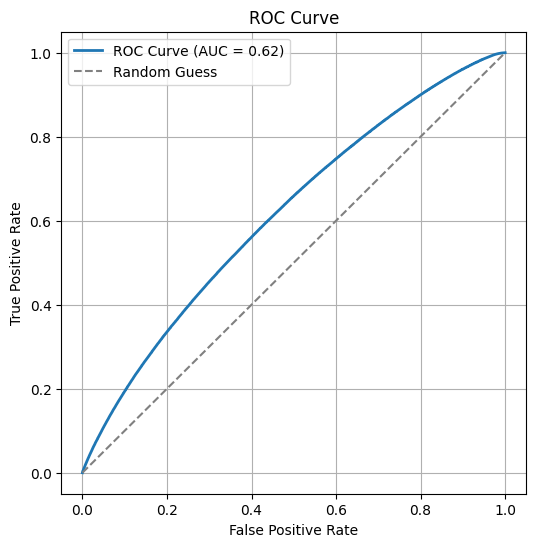

In [87]:
AUC_ROC(expanded_df['outcome'], expanded_df['predictions'], 'LR_ROC_plot.png')

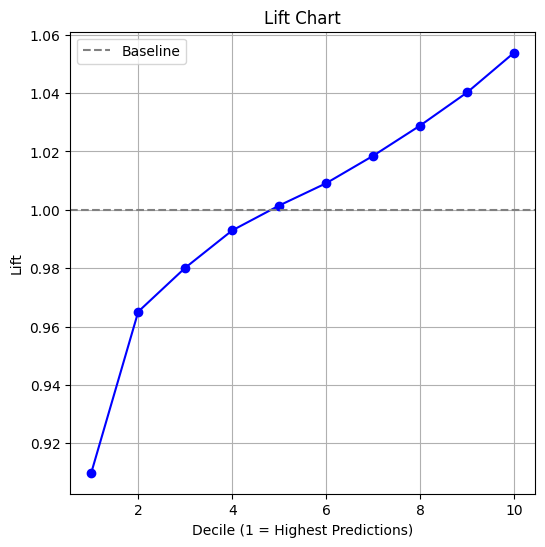

In [90]:
plot_lift(expanded_df, expanded_df['predictions'], 'LR_lift_plot.png')

In [ ]:
# Save to file all charts
coefficients_df.to_csv(out_filepath('LR_coefficients.txt'), sep='\t')
resiuals_plot.savefig(out_filepath('visualizations/LR_residuals_hist.png'))
predictions_scatterplot.savefig(out_filepath('visualizations/LR_predictions_scatterplot.png'))
p_recall_histogram.savefig('visualizations/LR_recall_histograms.png')